# Task 1
(A short summary of task 3 is available at the end of the notebook)

In [2]:
import keras
import h5py
import numpy as np
import random
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.layers import BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
f =  h5py.File("electrons.hdf5", 'r')
keys = list(f)
elect_x = f[keys[0]][:]
elect_y = f[keys[1]][:]

f =  h5py.File("photons.hdf5", 'r')
keys = list(f)

phot_x = f[keys[0]][:]
phot_y = f[keys[1]][:]

In [4]:
phot_x.shape, elect_x.shape

((249000, 32, 32, 2), (249000, 32, 32, 2))

Reduced the dimentionality of the data to 2, to visualize the dataset and see whether any patters are present in the dataset.

In [48]:
pca = PCA(n_components=2)

elect_pca = elec_x.reshape(249000,-1,2)
phot_pca = phot_x.reshape(249000,-1,2)

print(elect_pca[:,:,0].shape)

elect_pca = pca.fit_transform(elect_pca[:,:,0])
phot_pca = pca.fit_transform(phot_pca[:,:,0])

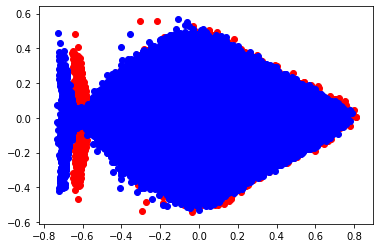

In [54]:
plt.scatter(elect_pca[:,0],elect_pca[:,1],color='r')
plt.scatter(phot_pca[:,0],phot_pca[:,1],color='b')

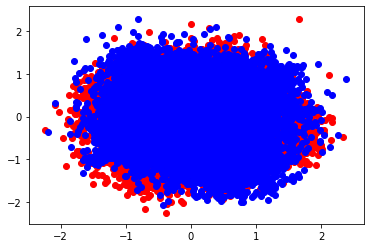

In [56]:
elect_pca = elec_x.reshape(249000,-1,2)
phot_pca = phot_x.reshape(249000,-1,2)

elect_pca = pca.fit_transform(elect_pca[:,:,1])
phot_pca = pca.fit_transform(phot_pca[:,:,1])

plt.scatter(elect_pca[:,0],elect_pca[:,1],color='r')
plt.scatter(phot_pca[:,0],phot_pca[:,1],color='b')

In [5]:
random.shuffle(elect_x)
random.shuffle(phot_x)

set_size = 249000

splice_e = elect_x[:set_size]
splice_p = phot_x[:set_size]

features = np.vstack((splice_p,splice_e))
labels = np.concatenate((phot_y[:set_size],elect_y[:set_size]))

In [6]:
encoder = LabelEncoder()
encoder.fit(labels)
labels = encoder.transform(labels)

In [7]:
features.shape, labels.shape

((498000, 32, 32, 2), (498000,))

In [8]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=10)

In [9]:
len(x_train), len(y_train)

(398400, 398400)

In [10]:
x_train = x_train.reshape(x_train.shape[0],-1)
x_test = x_test.reshape(x_test.shape[0],-1)

In [11]:
input_size = x_train.shape[-1]

In [19]:
log_file = 'log_file'
class LogSave(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        with open(log_file, 'w') as f:
            f.write(str(epoch))

log_save = LogSave()

csv_logger = CSVLogger('training.log', append=True)

- Ran the below cells several times to fine tune the model. The results shown here are from the final run, which does not reflect the model with the best accuracy. 
- I have loaded the best model at the end and evaluated it again.

In [17]:
model = Sequential()
model.add(Dense(input_size, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(input_size//2, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(input_size//8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(input_size//32, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(input_size//128, activation='relu'))
model.add(Dense(1, activation='relu'))

adam = Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.build((None,input_size))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

Stopped the model halfway since it did not show any improvement.

In [20]:
filepath="best-model-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(x_train, y_train, epochs=60,validation_data=(x_test,y_test), batch_size=1024,callbacks=[checkpoint, log_save, csv_logger])

Train on 398400 samples, validate on 99600 samples
Epoch 1/60
398400/398400 [==============================] - 170s 425us/step - loss: 0.7358 - accuracy: 0.5516 - val_loss: 0.6661 - val_accuracy: 0.5941

Epoch 00001: val_accuracy improved from -inf to 0.59407, saving model to best-model-0.59.hdf5
Epoch 2/60
398400/398400 [==============================] - 172s 432us/step - loss: 0.6645 - accuracy: 0.6029 - val_loss: 0.6559 - val_accuracy: 0.6156

Epoch 00002: val_accuracy improved from 0.59407 to 0.61560, saving model to best-model-0.62.hdf5
Epoch 3/60
398400/398400 [==============================] - 163s 410us/step - loss: 0.6416 - accuracy: 0.6315 - val_loss: 0.6297 - val_accuracy: 0.6429

Epoch 00003: val_accuracy improved from 0.61560 to 0.64294, saving model to best-model-0.64.hdf5
Epoch 4/60
398400/398400 [==============================] - 167s 419us/step - loss: 0.6145 - accuracy: 0.6604 - val_loss: 0.6129 - val_accuracy: 0.6705

Epoch 00004: val_accuracy improved from 0.64294 t

KeyboardInterrupt: 

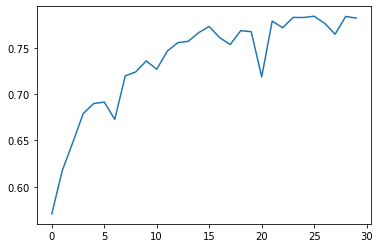

In [22]:
plt.plot(history.history['val_accuracy'])

In [12]:
model = load_model("best-model-0.84.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [13]:
model.evaluate(x_test.reshape(x_test.shape[0],-1), y_test)

99600/99600 [==============================] - 46s 466us/step


[0.5204415727930375, 0.8432731032371521]

In [14]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)               

In [16]:
model.save("best/acc_0.8432.h5")

# Task 3

In [23]:
import tensorflow as tf
from tensorflow.python.framework.graph_util import convert_variables_to_constants

In [24]:
from keras import backend as K

In [25]:
sess = K.get_session()

Exported the tensorflow graph to be loaded to the CMSSW enviroment.

In [26]:
def freeze_session(session, keep_var_name=None, output_names=None, clear_device=True):
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_name or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_device:
            for node in input_graph_def.node:
                node.device = ""
        
        frozen_graph = convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
        
        return frozen_graph
        

In [27]:
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 110 variables.
INFO:tensorflow:Converted 110 variables to const ops.


In [29]:
tf.train.write_graph(frozen_graph, "/home/jupyter", "graph.pb", as_text=False)

'/home/jupyter/graph.pb'

Then I imported the computational graph to the cmssw enviroment using graphLoading_cfg.py file. <br>
I used the code available here https://gitlab.cern.ch/mrieger/CMSSW-DNN as an example.

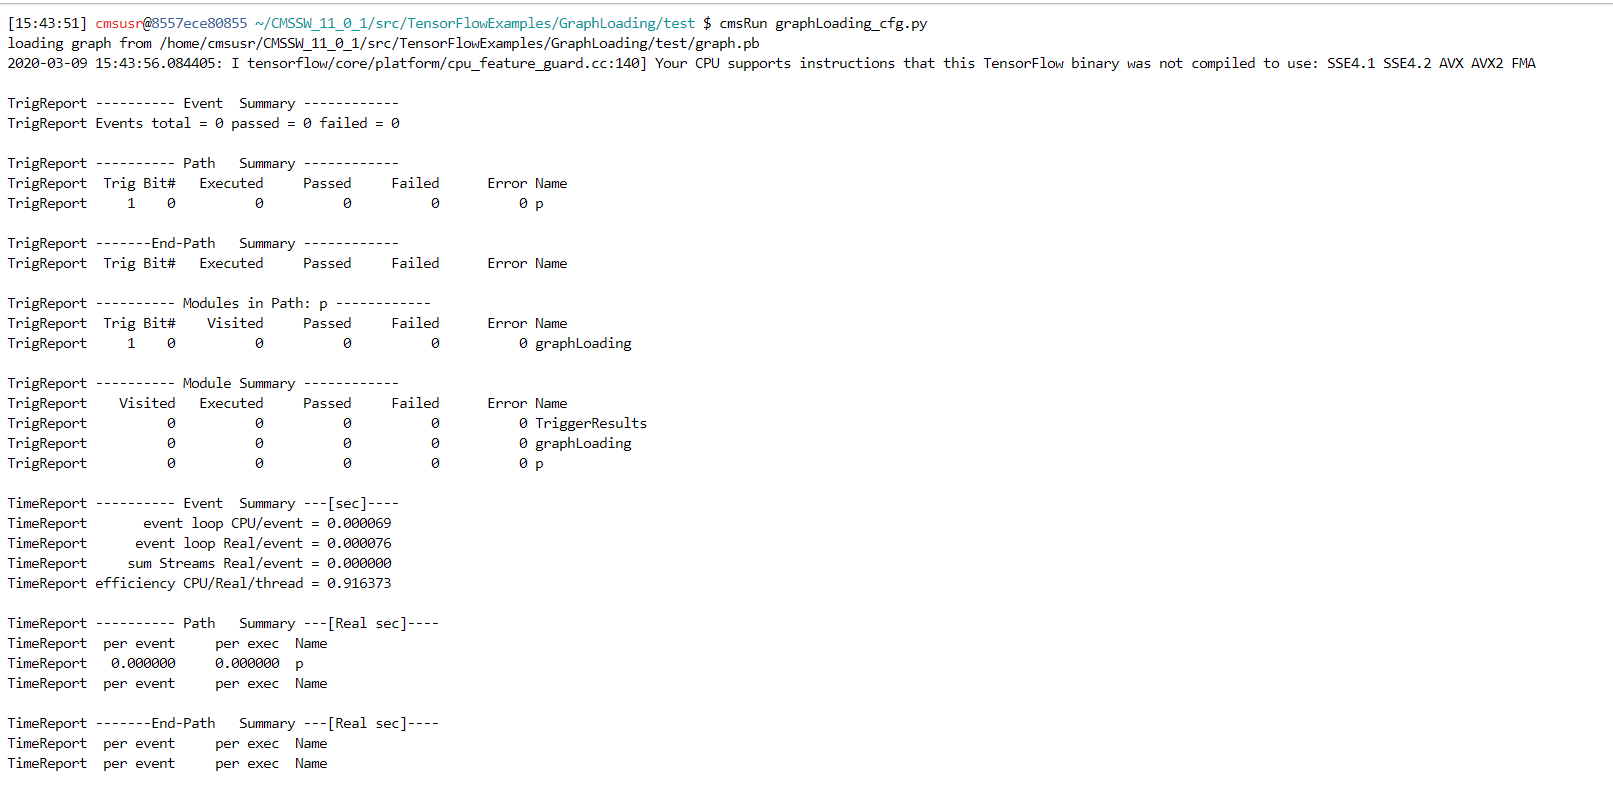

In [3]:
from IPython.display import Image
Image('cmssw.png')

Since I couldn't find a method to input non .root files as an input I was not able to run the evalation on the CMSSW and check whether the graph was loaded succesfully.